In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Algorythme d'optimisation pour problème lisse

Algorithme d'optimisation d'un problème lisse :
 - Descente de gradient (ajouter des termes d'accélérations à la Nesterov),
 - Newton,
 - Quasi-Newton, 
 - Forward-backward, 
 - Douglas-Rachford, 
 - Chambolle-pock.
 - (Avec pénalisation)Frank-Wolfe.


In [99]:
l = 1
v = 2
tau = 5
nx = 5
nt = 5
grid = np.linspace(0,l,nx,endpoint=False)

In [100]:
cfl = v*(tau/nt)/(l/nx)
flow = (1-cfl)*np.eye(nx) + cfl*np.diag(np.ones(nx-1),-1)

# moment of order k
xk = l/nx*np.ones(nx)
T = np.zeros((nt,nx))
for i in range(nt):
    T[i,:] = xk
    xk = flow.dot(xk)


In [101]:
mu, sigma = l/2, 0.1*l # mean and standard deviation
x = 1/(sigma*math.sqrt(2*math.pi))*np.exp(-0.5*(grid-mu)**2/sigma**2)
noise = 0.1
xi = noise*np.random.normal(0,0.1, nt)
y = T.dot(x)
yd = T.dot(x) + xi

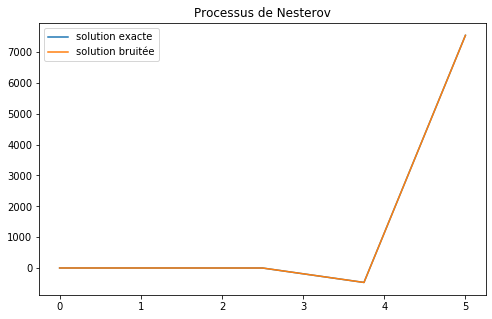

In [102]:
# taille de la figure
plt.figure(figsize=(8,5))
grid_t = np.linspace(0,tau,nt)
plt.title("Processus de Nesterov")
plt.plot(grid_t, y, label="solution exacte")
plt.plot(grid_t, yd, label="solution bruitée")
plt.legend()
plt.show()

In [103]:
np.linalg.norm(y-yd)/np.linalg.norm(y)

1.5128943464101596e-06

In [104]:
alpha = math.sqrt(tau/nt*np.linalg.norm(y-yd))
alpha

0.1069337467044828

In [105]:
from scipy.linalg import eigvalsh 
L = eigvalsh(tau/nt*np.transpose(T).dot(T)).max()

In [106]:
def f(x):
    return 0.5*tau/nt*np.linalg.norm(T.dot(x)-yd)**2+0.5*alpha*np.linalg.norm(x)**2
def df(x):
    return tau/nt*np.transpose(T).dot(T.dot(x)-yd)+alpha*x
def ddf(x):
    return tau/nt*np.transpose(T).dot(T) + alpha*np.eye(nx)

# Descente de gradient 

# Processus de Nesterov

In [107]:
def Nesterov(x0,f,df,tau=1/L,eps=10**-6,Niter=10000):
    xk = x0.copy()
    xkm = x0.copy()
    for k in range(Niter):
        yk = xk+(k/2)/(1+(k+1)/2)*(xk - xkm)
        xk, xkm = yk-tau*df(yk), xk
        if np.linalg.norm(df(xk))<eps:
            print("Number of iterations {}".format(k))
            return xk
    print("Final error eps = {}".format(np.abs(f(xk))))
    print("Max iteration of {} reached".format(Niter))
    return xk  

In [108]:
x0 = np.transpose(T).dot(yd)
xhat = Nesterov(x0,f,df)

Final error eps = 1427.2636152353405
Max iteration of 10000 reached


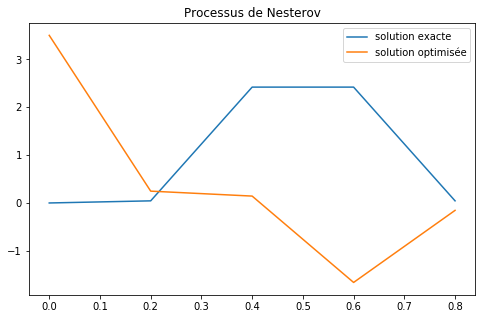

In [109]:
# taille de la figure
plt.figure(figsize=(8,5))
plt.title("Processus de Nesterov")
plt.plot(grid, x, label="solution exacte")
plt.plot(grid, xhat, label="solution optimisée")
plt.legend()
plt.show()

## Newton

In [126]:
def Newton(x0,f,df,ddf,eps=10**-12,Niter=10000):
    xk = x0.copy()
    for k in range(Niter):
        ddfk = ddf(xk)
        if np.linalg.norm(df(xk))<eps:
            print("Number of iterations {}".format(k))
            return xk
        if np.linalg.norm(ddfk) < eps:
            raise Exception(f"La dérivée |ddf| = {np.linalg.norm(ddfk)} est trop petite")
        ddf_inv = np.linalg.inv(ddfk)
        xk-= ddf_inv.dot(df(xk))
    print("Final error eps = {}".format(np.abs(f(xk))))
    print("Max iteration of {} reached".format(Niter))
    return xk

In [127]:
x0 = np.transpose(T).dot(yd)
xhat1 = Newton(x0,f,df,ddf)

Final error eps = 0.6014990117311854
Max iteration of 10000 reached


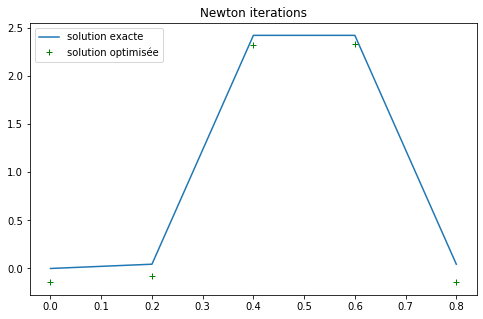

In [128]:
# taille de la figure
plt.figure(figsize=(8,5))
plt.title("Newton iterations")
plt.plot(grid, x, label="solution exacte")
plt.plot(grid, xhat1,'g+',label="solution optimisée")
plt.legend()
plt.show()

Conclusion : pour obtenur des résultats théoriques, il faut prendre un problème très spécifique, mais qui rentre à peu près dans les cases de l'analyse convexe, et en déduire des propriétés supplémentaires/des améliorations algorithmiques, qui peuvent être validées ou non expérimentalement.

In [113]:
np.linalg.norm(xhat1-xhat)

5.830621380474114

## Quasi-Newton - BFGS method

Given starting point x0, convergence tolerance

Inverse Hessian approximation H0; 

k ← 0;

while ∇fk > eps ;

Compute search direction
pk = -Hk $\nabla$ fk > 0,

Set xk+1=xk + αk pk where αk is computed from a line search procedure to satisfy the Wolfe conditions (3.6);
he values c1 =10−4 and c2 = 0.9 are commonly used

Define sk=xk+1 −xk 
and yk=∇fk+1 −∇fk; 

Compute Hk+1 by means of (6.17);

k ← k + 1;

end (while)

In [123]:
def BFGS(x0,f,df,ddf,eps=10**-12,Niter=5):
    c1, c2 = 10**-4, 0.9
    xk = x0.copy()
    dfk = df(xk)
    ddfk = ddf(xk)
    Hk = np.linalg.inv(ddfk)
    for k in range(Niter):
        if np.linalg.norm(dfk)<eps:
            print("Number of iterations {}".format(k))
            return xk
        if np.linalg.norm(ddfk)<eps:
            raise Exception("The hessian |ddf| = {} is two small".format(np.linalg.norm(ddfk)))
        # pk
        pk = - Hk.dot(dfk)
        # alphak
        alphak = 1
        cond1 = f(xk+alphak*xk)-f(xk)- c1*alphak*dfk.T.dot(pk)
        cond2 = df(xk+alphak*xk).T.dot(pk)-c2*dfk.T.dot(pk)
        if (cond1>0) or (cond2>0) :
            alphak-=0.001
        # xk+1
        xkm = xk.copy()
        xk = xkm + alphak*pk 
#         # sk, yk, rhok
#         sk = np.array([xk - xkm])
#         yk = np.array([df(xk)- dfk])
#         rhok = (yk.T.dot(sk))**-1
#         # Hk
#         print(Hk)
#         Hk = (np.eye(nx)-rhok*sk.dot(yk.T)).dot(Hk).dot(np.eye(nx)-rhok*yk.dot(sk.T)) + rhok*sk*sk.T
        # update
        dfk = df(xk)
        ddfk = ddf(xk)
    print("Final error eps = {}".format(np.linalg.norm(dfk)))
    print("Max iteration of {} reached".format(Niter))
    return xk

In [124]:
x0 = np.transpose(T).dot(yd)
xhat2 = BFGS(x0,f,df,ddf)

Final error eps = 2.943953641233058
Max iteration of 5 reached


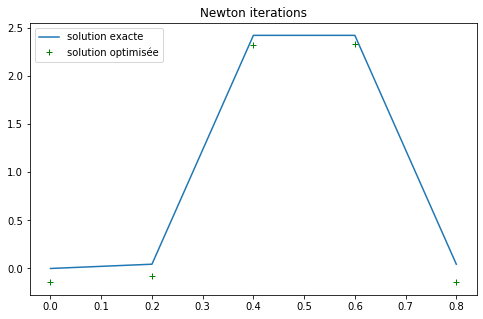

In [125]:
# taille de la figure
plt.figure(figsize=(8,5))
plt.title("Newton iterations")
plt.plot(grid, x, label="solution exacte")
plt.plot(grid, xhat2,'g+',label="solution optimisée")
plt.legend()
plt.show()